## Exercise 4

In [1]:
# Import required libraries
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch import nn, optim
import tqdm
import time

In [2]:
# Define the matrices
H = np.array([[1, 0], [0, 1]]) * 0.1
M = np.array([[1, 0], [0, 1]])
sigma = np.array([[1, 0], [0, 1]]) * 0.001
C = np.array([[0, 0], [0, 0]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[1, 0], [0, 1]]) * 10

# Initial and terminal times for solving the Ricatti
t0 = 0.0
T = 1.0

# Inputs required by the networks
time_tensor_dim = 1
space_tensor_dim = 1 * 2

dmg_hidden_layer_size = 100

In [3]:
# Retrieve the LQRProblem class from exercise 1
class LQRProblem:
    def __init__(self, H, M, C, D, R, sigma, T):
        """
        Initializes the LQR problem with the given matrices and time horizon T.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.S_solution, self.time_solution = None, None  # Will be set after solving Riccati ODE
    
    def riccati_ode(self, t, S_flat, H, M, D_inv, C):
        """
        Defines the Riccati differential equation.
        """
        S = S_flat.reshape(2, 2)
        dSdt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
        return dSdt.flatten()
    
    def solve_riccati_ode(self, time_grid, atol=1e-10, rtol=1e-10):
        """
        Solves the Riccati ODE on the given time grid using scipy's solve_ivp.
        """
        D_inv = np.linalg.inv(self.D)
        S0_flat = self.R.flatten()
        sol = solve_ivp(
            self.riccati_ode, 
            [self.T, time_grid[0]], 
            S0_flat, 
            t_eval=time_grid[::-1], 
            args=(self.H, self.M, D_inv, self.C), 
            atol=atol, 
            rtol=rtol,
            method='Radau'  # This is a common choice for stiff ODEs
        )
        self.S_solution = sol.y.reshape(2, 2, len(time_grid))[:, :, ::-1]
        self.time_solution = sol.t[::-1]
        return self.S_solution, self.time_solution


    def compute_value_function(self, t_tensor, x_tensor):
        """
        Computes the control problem value v(t, x) for a batch of space x using the solution of S
        and includes the integral term.
        """
       
        batch_size = x_tensor.shape[0]
        
        # Convert all relevant data to PyTorch tensors
        sigma_tensor = torch.tensor(self.sigma, dtype=torch.float64)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float64)
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float64)
        dt = solution_time[1] - solution_time[0]
        
        sigma_squared = sigma_tensor @ sigma_tensor.T
        
        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float64), dim=1)
        
        # Initialize v
        v = torch.zeros(batch_size, 1, dtype=torch.float64)
        
        # Pre-compute trace values for each S_tensor slice, to be used in batch operations
        trace_values = torch.einsum('ij,jik->k', sigma_squared, S_tensor)
        
        # Compute the cumulative sum of trace values for integral computation
        cum_integral = torch.cumsum(trace_values, dim=0) * dt
        
        # Adjust cum_integral by subtracting the cumulative sum up to each t, to effectively start from each t
        adjusted_integral = cum_integral[-1] - cum_integral
        
        for i in range(batch_size):
            idx = time_indexes[i]
            
            # Calculate the integral from t to T
            integral_term = adjusted_integral[idx]
            
            # Calculate v for each batch
            S_at_t = S_tensor[:, :, idx]

            if x_tensor[i].shape != (1, 2):
                x_T = x_tensor[i].reshape(1, 2)
                x = x_tensor[i].reshape(1, 2).T
            v[i] = x_T @ S_at_t @ x + integral_term

        return v

    def compute_markov_control(self, t_tensor, x_tensor):
        """
        Computes the Markov control function for a batch of x at time t using S(t).
        """
        batch_size = x_tensor.shape[0]

        # Find the index corresponding to the nearest time point in the time grid
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float64)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float64)

        # # Ensure t_tensor is 2D for broadcasting
        # t_tensor = t_tensor.unsqueeze(1)
        if t_tensor.shape != (batch_size, 1):
            # Reshape t_tensor to [1, batch_size]
            t_tensor = t_tensor.reshape(batch_size, 1)

        if x_tensor.dtype != torch.float64:
            x_tensor = x_tensor.to(torch.float64)

        if x_tensor.shape != (batch_size, 2):
            x_tensor = x_tensor.reshape(batch_size, 2)

        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float64), dim=1)

        # Initialize control
        control = torch.zeros(batch_size, 2, 1, dtype=torch.float64)

        D_inv = torch.tensor(np.linalg.inv(self.D), dtype=torch.float64)
        M_T = torch.tensor(self.M.T, dtype=torch.float64)

        # Compute the control using S(t)
        for i in range(batch_size):
            S_t = S_tensor[:, :, time_indexes[i]]

            if x_tensor[i].shape != (1, 2):
                x_T = x_tensor[i].reshape(1, 2).T

            control[i] = - D_inv @ M_T @ S_t @ x_T

        return control


In [4]:
# Retrieve given class DGM_Layer
class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output

In [5]:
# Retrieve given class Net_DGM
class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [6]:
# Retrieve given class FFN
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).to(torch.float64))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).to(torch.float64)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).to(torch.float64)

In [7]:
# Define helper functions to calculate the gradient and the hessian.
def calculate_gradient(u, x):
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return u_x

def calculate_hessian(u_x, x):
    hessian = torch.zeros(x.shape[0], x.shape [1],x.shape[1])
    for d in range(x.shape[1]):
        v_x = u_x[:,d].view(-1,1)
        grad_2 = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hessian[:,d] = grad_2
        u_xx = hessian.to(torch.float64)
    return u_xx

In [8]:
# Initialize the LQR problem class
LQR_class = LQRProblem(H, M, C, D, R, sigma, T)

# Set the time grid for solving the Riccati ODE and solve it
time_grid = np.linspace(t0, T, 10000)
LQR_class.solve_riccati_ode(time_grid)

(array([[[ 1.01192113,  1.0120033 ,  1.0120855 , ...,  9.98043678,
           9.99020871, 10.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 1.01192113,  1.0120033 ,  1.0120855 , ...,  9.98043678,
           9.99020871, 10.        ]]]),
 array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
        9.99799980e-01, 9.99899990e-01, 1.00000000e+00]))

100%|██████████| 10000/10000 [1:31:38<00:00,  1.75it/s]

MSE Loss: 15.172003714737565


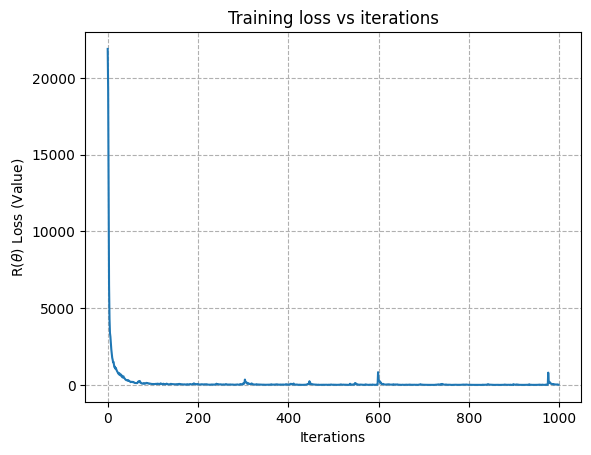

In [9]:
class DGM_for_PI(torch.nn.Module):

    def __init__(self, H, M, C, D, R, sigma):
        super().__init__()
        self.H = torch.tensor(H, dtype=torch.float64)
        self.M = torch.tensor(M, dtype=torch.float64)
        self.C = torch.tensor(C, dtype=torch.float64)
        self.D = torch.tensor(D, dtype=torch.float64)
        self.R = torch.tensor(R, dtype=torch.float64)
        self.sigma = torch.tensor(sigma, dtype=torch.float64)
        self.sigma_sigma_t = self.sigma @ self.sigma.T
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim + 2 - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,), gamma=0.1)

        # Define loss function for R(theta)
        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):    
            
            # Initialize the time space tensors for this iteration
            t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size),requires_grad=True).unsqueeze(1)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)

            # Retrieve the fixed controls for this iteration
            alpha_train = LQR_class.compute_markov_control(t_tensor, x_tensor.detach().reshape(batch_size, 1, 2))
            alpha_train = alpha_train.squeeze()

            # Calculate u_t, u_x, u_xx    
            u_of_tx = self.forward_mod(t_tensor, x_tensor, alpha_train)
            grad_u_t = calculate_gradient(u_of_tx, t_tensor)
            grad_u_x = calculate_gradient(u_of_tx, x_tensor)
            hessian_u_xx = calculate_hessian(grad_u_x, x_tensor)

            # Calculate each element of the pde    
            trace_sigma_hessian = torch.matmul(self.sigma_sigma_t, hessian_u_xx)
            trace_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_hessian)).reshape(batch_size, 1)
            gradu_H_x = (grad_u_x * torch.transpose((self.H @ x_tensor.T), 0, 1)).sum(axis=1).reshape(batch_size, 1)
            gradu_M_alpha = (grad_u_x * (self.M @ alpha_train.T).T).sum(axis=1).reshape(batch_size, 1)
            xT_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size, 1)
            aT_D_a = (alpha_train *  torch.transpose((self.D @ alpha_train.T),0,1)).sum(axis=1).reshape(batch_size, 1)

            # Sum the pde parts and create the target tensor which is zero
            pde = grad_u_t + trace_sigma_hessian + gradu_H_x + gradu_M_alpha + xT_C_x + aT_D_a
            target_zero_tensor = torch.zeros_like(pde)

            # First part of the cost function
            MSE_pde = loss_fn(pde, target_zero_tensor)

            # Calculate R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * LQR_class.T
            u_of_tx = self.forward_mod(t_tensor_terminal, x_tensor, alpha_train)
            target_boundary = (x_tensor *  torch.transpose((self.R @ x_tensor.T), 0, 1)).sum(axis=1).reshape(batch_size, 1)
            MSE_boundary = loss_fn(u_of_tx, target_boundary)

            # Calculate loss values and store them
            loss = MSE_pde + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)

        if plot:
            # Plot training loss graph
            print('MSE Loss: {}'.format(loss))
            plt.plot(losses[0::10])
            plt.grid(True, which="both", ls="--")
            plt.title('Training loss vs iterations')
            plt.xlabel('Iterations')
            plt.ylabel(r'R($\theta$) Loss (Value)')
            plt.show()

    def forward_mod(self, t_tensor, x_tensor, a_tensor):
        a_tensor = a_tensor.squeeze()
        return self.net_dgm.forward(t_tensor, torch.cat((x_tensor, a_tensor), dim=1)).to(torch.float64)
    
DGM_PI_model = DGM_for_PI(H, M, C, D, R, sigma)
DGM_PI_model.fit(2000, 10000, plot=True)

In [10]:
# Define mean error
class MeanErrorLoss(nn.Module):
    def __init__(self):
        super(MeanErrorLoss, self).__init__()

    def forward(self, input, target):
        return (input - target).mean()


Training started
Iteration: 1000/6000 | Total time: 145.61392450332642 seconds
Iteration: 2000/6000 | Total time: 307.04924058914185 seconds
Iteration: 3000/6000 | Total time: 458.1056478023529 seconds
Iteration: 4000/6000 | Total time: 619.6547558307648 seconds
Iteration: 5000/6000 | Total time: 818.2834227085114 seconds


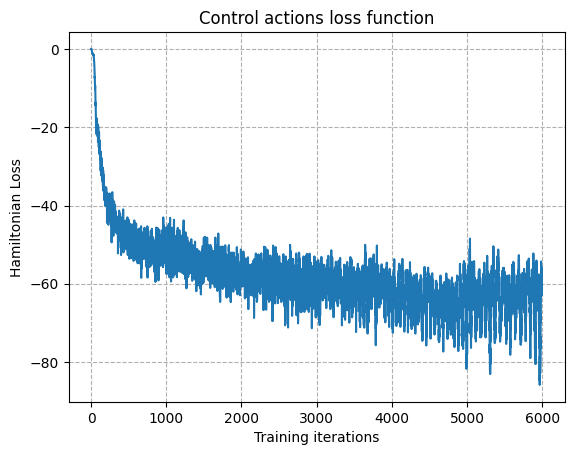

In [11]:
# ----- POLICY ITERATION MODEL TRAIN ----- #

# Set batch size
batch_size = 2000

# Define network layer sizes
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]

# Define the network for the optimal control and its optimizer
alpha_model = FFN(sizes = sizes)
optimizer_a = torch.optim.Adam(alpha_model.parameters(), lr=0.001)

# Define the neural network for the optimal value function and its optimizer
value_model = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)
optimizer_v = torch.optim.Adam(value_model.parameters(), lr=0.001)

# Retrieve the trained Deep Galerkin Model, which finds the optimal value function for a fixed control a
target_value_model = DGM_PI_model

losses_a = []
losses_v = []

for i in range(6000):
    
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)),requires_grad=True)
    x_reshaped = x_tensor.reshape(-1, 2)
    input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

    # Generate the candidate optimal control from the alpha model
    predicted_alpha = alpha_model.forward(input_tensor).to(torch.float64)

    # Feed it to the Deep Galerkin model to get the optimal PDE calculated target value
    DG_values = target_value_model.forward_mod(t_tensor, x_reshaped, predicted_alpha)

    # Generate the predicted value for this time space batch
    predicted_value = value_model.forward(t_tensor, x_reshaped)
    
    # Update theta val
    optimizer_v.zero_grad()
    mse_loss = nn.MSELoss()
    loss_v = mse_loss(predicted_value, DG_values)
    losses_v.append(loss_v.item())
    loss_v.backward(retain_graph=True)
    optimizer_v.step()
        
    # Approximate v using the trained model
    predicted_value = value_model.forward(t_tensor, x_reshaped)
    grad_u_x = torch.autograd.grad(predicted_value, x_reshaped, grad_outputs=torch.ones_like(DG_values), create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Calculate each term of the Hamiltonian
    term1 = torch.sum(grad_u_x * (torch.tensor(H, dtype=torch.float64) @ x_reshaped.T).T, dim=1, keepdim=True)              # (∇xv)ᵀHx
    term2 = torch.sum(grad_u_x * (torch.tensor(M, dtype=torch.float64) @ predicted_alpha.T).T, dim=1, keepdim=True)         # (∇xv)ᵀMa
    term3 = torch.sum(x_reshaped * (torch.tensor(C, dtype=torch.float64) @ x_reshaped.T).T, dim=1, keepdim=True)            # (x)ᵀCx
    term4 = torch.sum(predicted_alpha * (torch.tensor(D, dtype=torch.float64) @ predicted_alpha.T).T, dim=1, keepdim=True)  # aᵀDa

    # Combine the terms
    hamiltonian = term1 + term2 + term3 + term4

    # The exercise specifically requires the loss to be a simple average loss
    optimizer_a.zero_grad()
    mae_loss_h = MeanErrorLoss() 
    loss_a_ham = mae_loss_h(hamiltonian, torch.zeros_like(hamiltonian))
    loss_a_ham.backward(retain_graph=True)
    optimizer_a.step()
    losses_a.append(loss_a_ham.item())

    if i % 1000 == 0:
        if i == 0:
            start_time = time.time()  # Start timing
            print('Training started')
        else:
            end_time = time.time()  # End timing
            print('Iteration:', f'{i}/6000', '| Total time:', end_time - start_time, 'seconds')
 
 # Plot training loss graph
plt.plot(losses_v[1:])
plt.grid(True, which="both", ls="--")
plt.xlabel('Training iterations')
plt.ylabel(r'R($\theta$) Loss')
plt.title('Value function loss function')
plt.show()

 # Plot training loss graph
plt.plot(losses_a[1:])
plt.grid(True, which="both", ls="--")
plt.xlabel('Training iterations')
plt.ylabel('Hamiltonian Loss')
plt.title('Control actions loss function')
plt.show()

In [12]:
# Test on time space tensors of size 1
batch_size = 1

# Sample t uniformly on [0, T]
t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size)).unsqueeze(1)
x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 1, 2)))
x_reshaped = x_tensor.reshape(-1, 2)
input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare predicted controls and controls from 1.1
a_pred = alpha_model.forward(input_tensor).to(torch.float64).squeeze()
a_actual = LQR_class.compute_markov_control(t_tensor, x_tensor).squeeze()

print(f'MSE of a: {loss_fn(a_pred, a_actual)}')
print(f'True control {a_actual.detach().numpy()} \nPredicted control {a_pred.detach().numpy()}')

# Compare predicted optimal value and value from 1.1
v_pred = value_model.forward(t_tensor, x_reshaped).squeeze()
t_tensor_vi = t_tensor.squeeze(0)
x_tensor_vi = x_tensor.squeeze(0)
v_actual = LQR_class.compute_value_function(t_tensor_vi, x_tensor_vi).squeeze()

# plt.plot(np.array(v_pred), np.array(v_actual))
print(f'Absolute error of v: {abs(v_pred-v_actual)}')
print(f'Value actual {v_actual} \nValue prediction {v_pred}')

MSE of a: 0.10190265856652837
True control [-2.01194843  1.74588006] 
Predicted control [-1.81957135  1.33747294]
Absolute error of v: 0.8614670263359283
Value actual 6.257823528346238 
Value prediction 7.119290554682166


In [13]:
# Test on time space tensors of size 500
batch_size = 500

# Sample t, x uniformly on [0, T] and [-3, 3]
batch_t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size)).unsqueeze(1)
batch_x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
batch_x_reshaped = batch_x_tensor.reshape(-1, 2)
input_tensor = torch.cat((batch_t_tensor, batch_x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare predicted controls and controls from 1.1
a_pred = alpha_model.forward(input_tensor).to(torch.float64)
a_actual = LQR_class.compute_markov_control(batch_t_tensor, batch_x_tensor)
print(f'MSE of actions: {loss_fn(a_pred, a_actual.squeeze())}')

# Compare predicted optimal value and value from 1.1
v_pred = DGM_PI_model.forward_mod(batch_t_tensor, batch_x_reshaped, a_pred).squeeze() #DGM_PI_model.forward(batch_t_tensor, batch_x_reshaped).squeeze()
batch_t_tensor_vi = batch_t_tensor.T.squeeze(0)
v_actual = LQR_class.compute_value_function(batch_t_tensor_vi, batch_x_tensor).squeeze()
print(v_pred.shape, v_actual.shape)
print(f'MSE of value: {loss_fn(v_pred, v_actual)}')

MSE of actions: 3.6134336404076732
torch.Size([500]) torch.Size([500])
MSE of value: 43.47104063107309


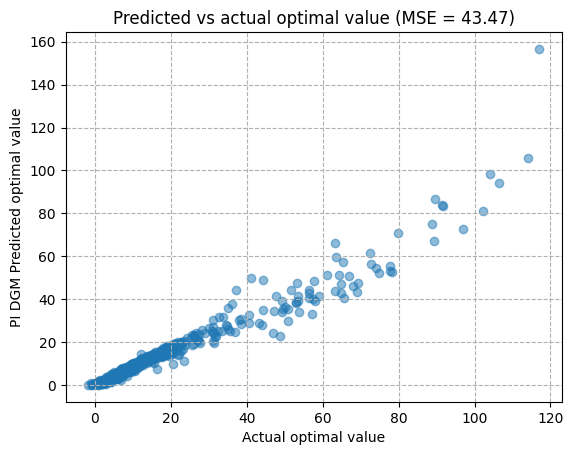

In [14]:
plt.scatter(v_pred.detach().numpy(), v_actual.detach().numpy(), alpha=0.5)
plt.grid(True, which="both", ls="--")
plt.title(f'Predicted vs actual optimal value (MSE = {(loss_fn(v_pred, v_actual)):.2f})')
plt.xlabel('Actual optimal value')
plt.ylabel('PI DGM Predicted optimal value')
plt.show()

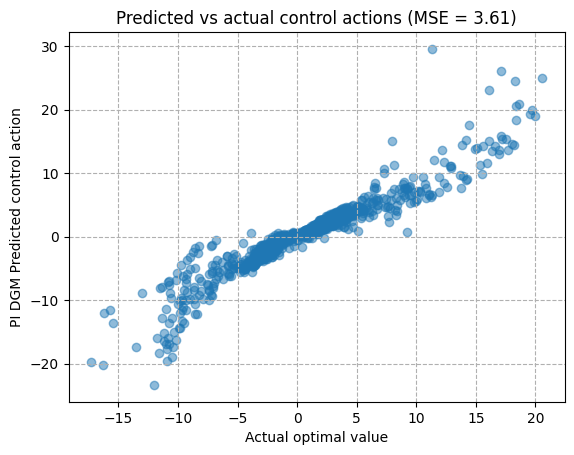

In [15]:
plt.scatter(a_pred.detach().numpy(), a_actual.detach().numpy(), alpha=0.5)
plt.grid(True, which="both", ls="--")
plt.title(f'Predicted vs actual control actions (MSE = {(loss_fn(a_pred, a_actual.squeeze())):.2f})')
plt.xlabel('Actual control action')
plt.ylabel('PI DGM Predicted control action')
plt.show()